In [3]:
import os
import re
from pathlib import Path

import anndata
import pandas as pd
import scanpy as sc
import sklearn
import scipy
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

In [6]:
from wombat.utils import listfiles

In [7]:
run_name = 'mCRC/combined_run_1'

In [8]:
output_dir = f'/storage1/fs1/dinglab/Active/Projects/estorrs/SpiceMix/analysis/{run_name}/inputs/files'
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [9]:
fps = sorted(listfiles('/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/mCRC',
                       regex=r'outs/filtered_feature_bc_matrix.h5$'))
len(fps), fps

(11,
 ['/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/mCRC/CRC_225C1/CRC_225C1_U2/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/mCRC/CRC_225C1/CRC_225C1_U3/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/mCRC/CRC_225C1/CRC_225C1_U4/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/mCRC/CRC_225C1/CRC_225C1_U5/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/mCRC/CRC_liver_HT225C1/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/mCRC/CRC_liver_HT230C1/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/c

CRC_225C1_U2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


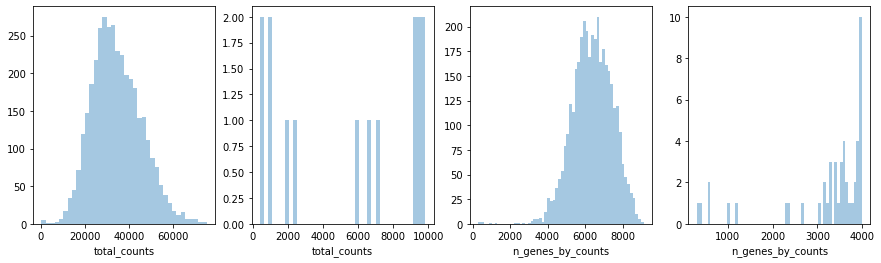

CRC_225C1_U3


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


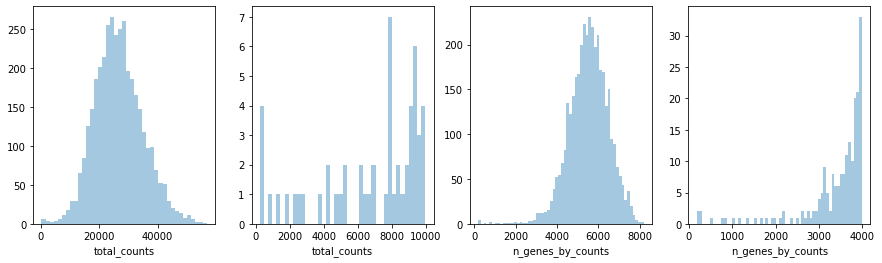

CRC_225C1_U4


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


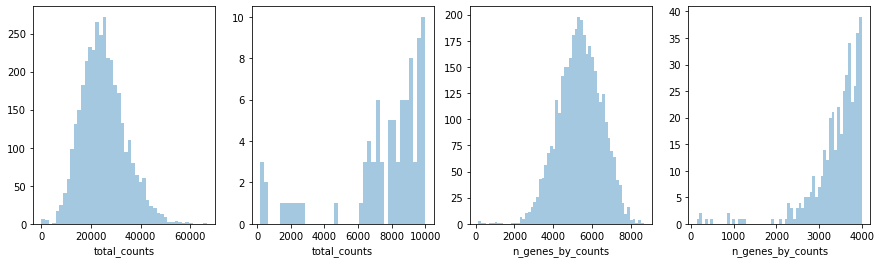

CRC_225C1_U5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


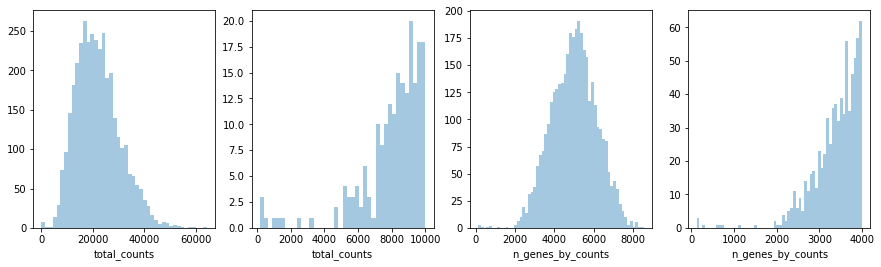

CRC_liver_HT225C1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


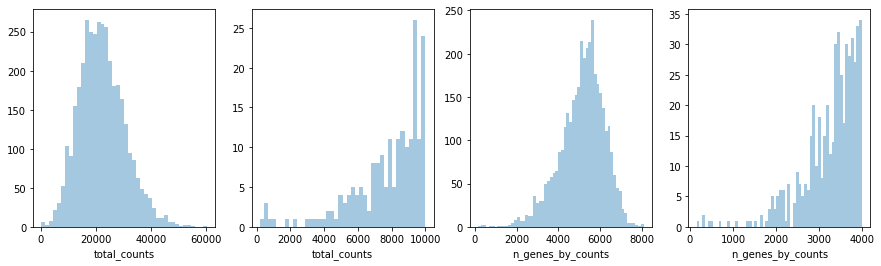

CRC_liver_HT230C1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


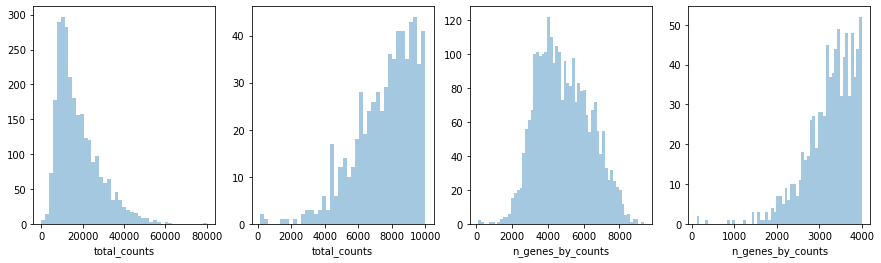

HT213C1A4U1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


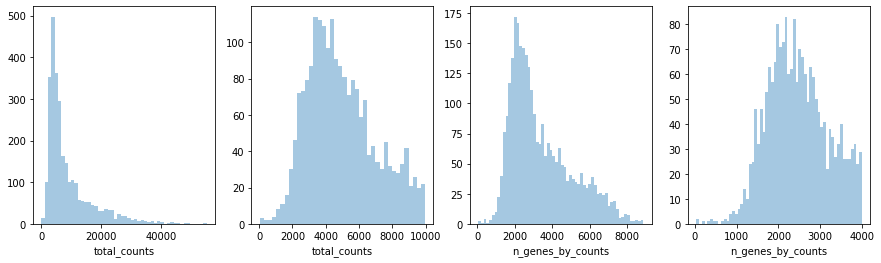

HT250C1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


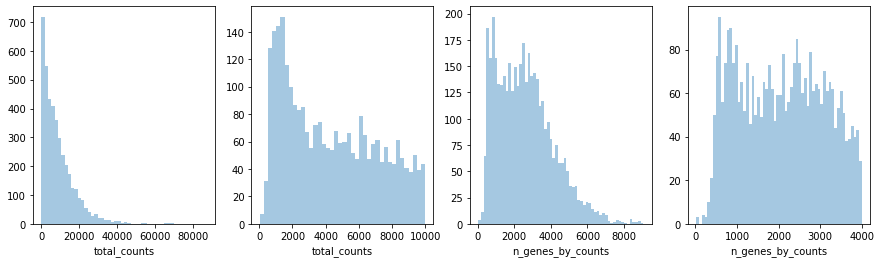

HT253C1T1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


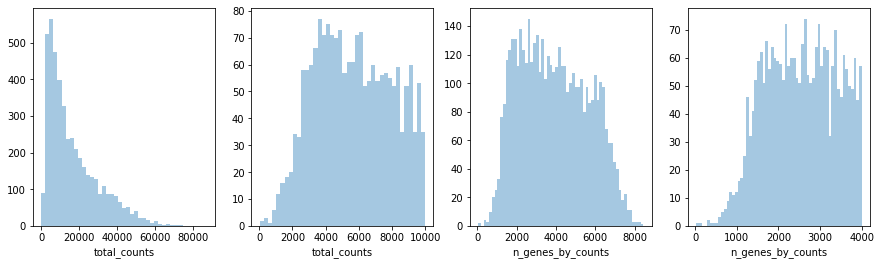

HT260C1Th1K1U1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


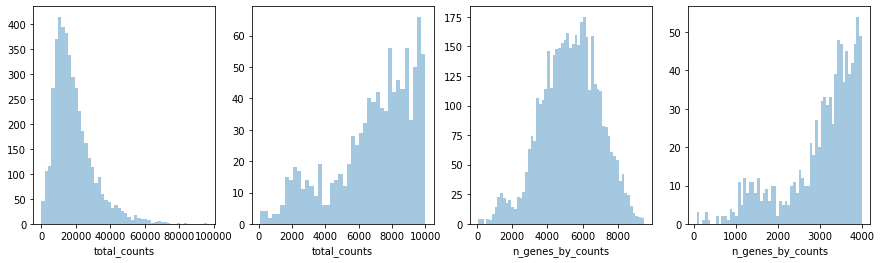

HT291C1U1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


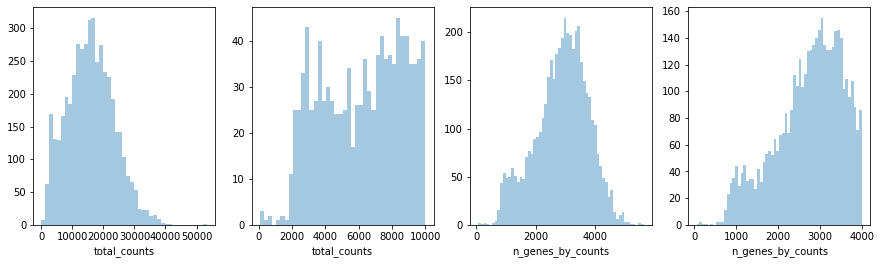

dict_keys(['CRC_225C1_U2', 'CRC_225C1_U3', 'CRC_225C1_U4', 'CRC_225C1_U5', 'CRC_liver_HT225C1', 'CRC_liver_HT230C1', 'HT213C1A4U1', 'HT250C1', 'HT253C1T1', 'HT260C1Th1K1U1', 'HT291C1U1'])

In [10]:
sample_to_adata = {}
for i, fp in enumerate(fps):
    s = fp.split('/')[-3]
    print(s)
    a = sc.read_visium(fp.replace('/filtered_feature_bc_matrix.h5', ''))
    a.var_names_make_unique()
    a.var["mt"] = a.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(a, qc_vars=["mt"], inplace=True)
    a.obs.index = [f'{s}_{x}' for x in a.obs.index]
    a.obs['sample_id'] = s
    a.obs['fov'] = str(i)
    sample_to_adata[s] = a

    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    sns.distplot(a.obs["total_counts"], kde=False, ax=axs[0])
    sns.distplot(a.obs["total_counts"][a.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
    sns.distplot(a.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.distplot(a.obs["n_genes_by_counts"][a.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
    plt.show()

sample_to_adata.keys()

In [11]:
for s, a in sample_to_adata.items():
    print(a.shape)
#     sc.pp.filter_cells(a, min_counts=1000)
#     a = a[a.obs["pct_counts_mt"] < 20]
    
    sc.pp.normalize_total(a, target_sum=10e4)
    sc.pp.log1p(a)
    
    a.raw = a
    
    sample_to_adata[s] = a
    
    print(a.shape)

(3681, 36601)
(3681, 36601)
(3710, 36601)
(3710, 36601)
(3688, 36601)
(3688, 36601)
(3657, 36601)
(3657, 36601)
(3721, 36601)
(3721, 36601)
(2697, 36601)
(2697, 36601)
(2876, 36601)
(2876, 36601)
(4082, 36601)
(4082, 36601)
(4617, 36601)
(4617, 36601)
(4405, 36601)
(4405, 36601)
(4591, 36601)
(4591, 36601)


In [12]:
def spot_to_neighbors(adata, n_neighbors=7, radius=400.):
    X = adata.obsm['spatial']
    nbrs = NearestNeighbors(algorithm='ball_tree').fit(X)
    
    g = nbrs.kneighbors_graph(X, n_neighbors=n_neighbors, )
#     g = nbrs.radius_neighbors_graph(X, radius=radius, )
    rows, cols, _ = scipy.sparse.find(g)
    
    spot_to_neighbhors = {x:[] for x in adata.obs.index.to_list()}
    for r, c in zip(rows, cols):
        cid = adata.obs.index[r]
        spot_to_neighbhors[cid].append(adata.obs.index[c])
    spot_to_neighbhors = {spot:[nbhr for nbhr in nbhrs if nbhr != spot]
                          for spot, nbhrs in spot_to_neighbhors.items()}
    return spot_to_neighbhors

In [13]:
for s, a in sample_to_adata.items():
    a.uns['spot_to_neighbors'] = spot_to_neighbors(a)

/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample_id' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'fov' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering ca

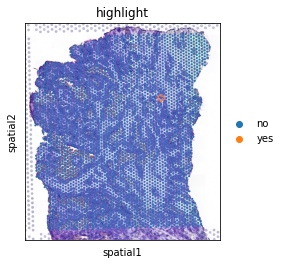

In [14]:
test = next(iter(sample_to_adata.values()))
test.obs['highlight'] = ['yes' if x in test.uns['spot_to_neighbors'][test.obs.index[100]] else 'no'
                      for x in test.obs.index]
sc.pl.spatial(test, color='highlight')

In [15]:
combined = anndata.concat(sample_to_adata.values())
combined.uns['spot_to_neighbors'] = {}
for s, a in sample_to_adata.items():
    combined.uns['spot_to_neighbors'].update(a.uns['spot_to_neighbors'])

combined

AnnData object with n_obs × n_vars = 41725 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'fov'
    uns: 'spot_to_neighbors'
    obsm: 'spatial'

In [16]:
# limit to genes with > 10% expression accross samples
combined.raw = combined
sc.pp.filter_genes(combined, min_counts=int(.1 * combined.shape[0]))
combined

AnnData object with n_obs × n_vars = 41725 × 13040
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'fov'
    var: 'n_counts'
    uns: 'spot_to_neighbors'
    obsm: 'spatial'

In [17]:
genes = combined.var.index.to_list()

In [18]:
for s, a in sample_to_adata.items():
    print(s)
    fov = a.obs['fov'][0]
    gene_table = a[:, genes].var[[]]
    gene_table.index.name = 'Gene'

    meta = a.obs[['array_row', 'array_col']]
    meta.columns = ['coor Y', 'coor X']

    exp = pd.DataFrame(data=a[:, genes].X.toarray(), columns=genes, index=a.obs.index)

    spot_to_index = {spot:i for i, spot in enumerate(a.obs.index)}
    edges = [[spot_to_index[spot1], spot_to_index[spot2]]
             for spot1, nbhrs in a.uns['spot_to_neighbors'].items()
             for spot2 in nbhrs]
    edges = pd.DataFrame(data=edges, columns=['Spot', 'Neighbor'])

    gene_table.to_csv(os.path.join(output_dir, f'genes_{fov}.txt'), sep='\t', index=True, header=False)
    meta.to_csv(os.path.join(output_dir, f'meta_{fov}.txt'), sep='\t', index=False, header=True)
    exp.to_csv(os.path.join(output_dir, f'expression_{fov}.txt'), sep='\t', index=False, header=False)
    edges.to_csv(os.path.join(output_dir, f'neighborhood_{fov}.txt'), sep='\t', index=False, header=False)

CRC_225C1_U2
CRC_225C1_U3
CRC_225C1_U4
CRC_225C1_U5
CRC_liver_HT225C1
CRC_liver_HT230C1
HT213C1A4U1
HT250C1
HT253C1T1
HT260C1Th1K1U1
HT291C1U1


In [19]:
directory = os.path.join(output_dir, '..', 'input_adatas')
Path(directory).mkdir(parents=True, exist_ok=True)
for s, a in sample_to_adata.items():
    a.write_h5ad(os.path.join(directory, f'{s}.h5ad'))

/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reorde

/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reorde

/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample_id' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'fov' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering ca